## Práctico de Introducción a Machine Learning

En este práctico implementaremos modelos sencillos de clasificiación para intentar predecir el ausentismo en los turnos. Vamos a experimentar con modelos lineales y con árboles de decisión. Nuestro objetivo no será construir el mejor modelo, sino ganar un poco más de intuición sobre nuestro conjunto de datos, y tomar algunas decisiones sobre las que profundizaremos en el próximo práctico.

### Preprocesamiento

Antes de aplicar los modelos, haremos un filtrado de los datos. Se sugiere seguir los siguientes pasos, pero pueden experimentar ustedes también otras alternativas

- Seleccionar sólo los registros cuyo estado de turno sea "Ausente" o "Atendido". Esta variable será nuestra variable objetivo, sobre la cual buscaremos hacer predicciones.

- Remover los siguientes registros:

    - Turnos con pacientes menores de edad. 

    - Turnos en días domingo.

    - Pacientes sin datos en columna "Sexo"

    - Consultas de guardia

    - Consultas de pediatría

    - Registros cuyo centro de atención sea "1" o "2"
    
- Crear los siguientes features:

    - **Anticipación de reserva**. Diferencia entre la fecha del turno y la fecha de otorgado. En caso de que la fecha de otorgado sea mayor a la del turno, colocar el valor 0.
    
    - **Día de la semana**. 
    
    - **Consulta médica**. Variable binaria construida a partir del campo "Prestación asignada", que vale 1 si la prestación es una consulta médica, o 0 si es de otro tipo.
    
    - **Consumidor final**. Variable binaria construida a partir del campo "Prestador", que vale 1 si se trata de un consumidor final, o 0 si cuenta con obra social o prepaga.
    
Una vez realizados los pasos previos (o los que ustedes consideren pertinentes) debemos decidir qué hacer con los valores nulos que hayan quedado. Dado que los modelos no pueden recibir valores nulos, es necesario tomar una decisión (descartarlos, reemplazarlos por algún valor representativo, descartar alguna columna, etc.). Utilicen el criterio que consideren adecuado en este caso.

Una vez que el dataset resultante no tenga valores nulos, es necesario transformar las variables categóricas en variables numéricas (es decir, realizar un encoding de los datos). Las recomendaciones en este caso son:

- Realizar one-hot encoding para los campos

    - Día de la semana 
    - Tipo de turno
    - Centro de atención
    
    
- Transformar en variables binarias los campos

    - Estado del turno ("Ausente" == 1, "Atendido" = 0)
    - Sexo
    - Es sobre turno
    - Consulta médica
    - Consumidor final
    
Pueden ver más sobre encoding [acá](https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd).

### Elección de los modelos

Con los pasos anteriores, nuestro dataset debería ser una tabla con valores numéricos y sin valores nulos. Ahora, deberán separar el conjunto de datos en conjunto de entrenamiento (train) y conjunto de prueba (test). Por ahora, no utilizaremos conjunto de validación. Se recomienda utilizar el método `train_test_split` de `scikitlearn`, con un 80% para train y 20% para test.

Una vez divididos los datos, construimos los modelos predictivos. Deberán elegir (al menos) dos modelos [lineales](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) y dos modelos basados en [árboles de decisión](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble). Entrenen cada modelo utilizando el conjunto de entrenamiento y los parámetros por defecto y evaluen la predicción utilizando las cuatro métricas descriptas más adelante. ¿Qué diferencias hay entre los distintos modelos? ¿Qué tan buenas son las predicciones?

Jueguen un poco variando algunos parámetros (no es necesario hacer una búsqueda sistemática). ¿Qué parámetros influyen más en el desempeño de los clasificadores? ¿Por qué les parece que algunos parámetros influyen más que otros?

Repitan el proceso pero normalizando los datos de entrada (pueden usar, por ejemplo `MinMaxScaler` o `StandardScaler`). ¿Hay alguna diferencia en el resultado de los modelos? ¿A qué se debe?

Finalmente, intenten mejorar las predicciones agregando o quitando features, o variando el tipo de encoding. En base a los resultados que vayan obteniendo, determinen los features que ustedes consideren que son más informativos (aquellos que ayudan a mejorar la predicción) y aquellos que sean redundantes, o que empeoren el resultado.

### Elección de métricas

Un aspecto fundamental del aprendizaje automático es la elección de métricas para evaluar los modelos predictivos. En este práctico vamos a explorar las siguientes cuatro métricas:

- Accuracy
- F1
- AUC ROC
- AUC Precision-Recall

Para cada uno de los modelos que utilicen, calculen las cuatro métricas. ¿Qué información brinda cada una? ¿Hay algún inconveniente en utilizar alguna de ellas? ¿Cuáles les parece que pueden ser de utilidad para nuestra problemática? Pueden encontrar información sobre las últimas dos [acá](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/).




In [1]:
import os
import numpy as np
import pandas as pd
import chardet
import string
np.random.seed(0)
import seaborn as sn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import re
import unidecode

In [2]:
dfp = pd.read_csv('turnos_con_paciente_2018-2019_despersonalizado.csv', sep=';')
dfsp = pd.read_csv('turnos_sin_paciente_2018-2019_despersonalizado.csv', sep=';')

#dfp = pd.read_csv(r'E:\anaconda3\envs\mentoria_ausentismo\aprendizajeautomatico\turnos_con_paciente_2018-2019_despersonalizado.csv', sep=';')
#dfsp = pd.read_csv(r'E:\anaconda3\envs\mentoria_ausentismo\aprendizajeautomatico\turnos_sin_paciente_2018-2019_despersonalizado.csv', sep=';')

In [3]:
## Renombramos columnas
to_rename = {
    'Centro de atención': 'CentroDeAtencion',
    'Prestación asignada': 'Prestacion',
    'Estado del turno': 'EstadoDelTurno',
    'Nombre del canal': 'Canal',
    'Fecha del turno': 'FechaDelTurno',
    'Hora del turno': 'HoraDelTurno',
    'Es sobre turno': 'EsSobreTurno',
    'Tipo de turno asignado': 'TipoDeTurno'
        }
dfsp_r = dfsp.rename(columns=to_rename)

In [4]:
## Parseamos fechas
dfsp_r.FechaDelTurno = dfsp_r.FechaDelTurno + ' ' + dfsp_r.HoraDelTurno
dfsp_r.FechaDelTurno = pd.to_datetime(dfsp_r.FechaDelTurno)
dfsp_r = dfsp_r.drop(columns=['HoraDelTurno'])

In [5]:
## Renombramos columnas
to_rename = {
    'CentroAtencion_Nombre': 'CentroDeAtencion',
    'Servicio_Nombre': 'Servicio',
    'TurnoEstado_Nombre': 'EstadoDelTurno',
    'FechaTurno': 'FechaDelTurno',
    'TipoTurno': 'TipoDeTurno',
    'Dirección (localidad)' : 'Localidad',
    'Dirección (provincia)' : 'Provincia',
    'FechaOtrogado' : 'FechaOtorgado'
    }
dfp_r = dfp.rename(columns=to_rename)

In [6]:
## Parseamos fechas
dfp_r.FechaDelTurno = pd.to_datetime(dfp_r.FechaDelTurno)

In [7]:
##Hacemos minúscula todo
dfp_r.Localidad = dfp_r.Localidad.str.lower()
dfp_r.Provincia = dfp_r.Provincia.str.lower()

In [8]:
dfp_r.Localidad.replace(['-', ' '], 'No definido', inplace=True)
dfp_r.loc[dfp_r.Localidad.isnull(), 'Localidad'] = 'No definido'
dfp_r.Provincia.replace(['-', ' '], 'No definido', inplace=True)
dfp_r.loc[dfp_r.Provincia.isnull(), 'Provincia'] = 'No definido'

In [9]:
##Reemplazamos todos los _Córdoba_ mal escritos (ya revisados) por "cordoba"
Mal_Escrito = ['cba', 'cordiba', 'cordo', 'cordobacapital', 'cordobacapitral', 'cordonba', 'corodba', 'crdoba', 'ordoba']
dfp_r.Localidad.replace(Mal_Escrito,'cordoba', inplace=True)
dfp_r.Provincia.replace(Mal_Escrito,'cordoba', inplace=True)

In [10]:
#Localidad
##Evaluamos y reemplazamos los que tenemos dudas (ya revisados), por "cordoba" 
Duda = ['capital', 'centro']
dfp_r.loc[(dfp_r.Provincia == 'cordoba') & (dfp_r.Localidad.isin(Duda)), 'Localidad'] = 'cordoba'

In [11]:
#Provincia
##Reemplazamos los posibles "nodefinido" por "cordoba" en Provincia, cuando Localidad='cordoba'
dfp_r.loc[dfp_r.Localidad == 'cordoba', 'Provincia'] = 'cordoba'

In [12]:
##Reemplazamos todo lo que no es "cordoba" por "otro"
dfp_r.loc[(dfp_r.Provincia != 'cordoba') , 'Provincia'] = 'otro'
dfp_r.loc[(dfp_r.Provincia == 'nodefinido'), 'Provincia'] = 'otro'
dfp_r.loc[(dfp_r.Localidad != 'cordoba') , 'Localidad'] = 'otro'
dfp_r.loc[(dfp_r.Localidad == 'nodefinido'), 'Localidad'] = 'otro'

In [13]:
dfp_r.EstadoDelTurno= dfp_r.EstadoDelTurno.replace ({'Atendiendo' :'Atendido','Asignado':'Atendido','Receptado':'Atendido'})

In [14]:
dfsp_r_t= dfsp_r[dfsp_r.EstadoDelTurno.isin (['Atendido','Ausente'])]

In [15]:
dfsp_r_t.EstadoDelTurno.unique()

array(['Atendido', 'Ausente'], dtype=object)

In [16]:
cols = [
    'CentroDeAtencion', 'Servicio', 'Recurso', 'FechaDelTurno', 
    'EstadoDelTurno', 'Prestacion', 'TipoDeTurno'
]
df = dfp_r.merge(dfsp_r_t, on=cols)
df.head()

,CentroDeAtencion,Prestador,Recurso,Servicio,FechaDelTurno,EstadoDelTurno,Sexo,Edad,HC,TipoDeTurno,Prestacion,FechaOtorgado,Localidad,Provincia,Canal,EsSobreTurno
0,1,MEDIFE ASOCIACIÓN CIVIL,253,GUARDIA DE PEDIATRIA,2018-01-01 11:57:00,Atendido,F,4,0.0,Ulterior / Control,CONSULTA MEDICA,2018-01-01 11:58:10.047000,otro,otro,NaN,SI
1,1,MEDIFE ASOCIACIÓN CIVIL,253,GUARDIA DE PEDIATRIA,2018-01-01 12:20:00,Atendido,M,3,1.0,Ulterior / Control,CONSULTA MEDICA,2018-01-01 12:20:46.097000,otro,otro,NaN,SI
2,1,DASPU,253,GUARDIA DE PEDIATRIA,2018-01-01 12:23:00,Atendido,M,3,2.0,Ulterior / Control,CONSULTA MEDICA,2018-01-01 12:25:39.333000,otro,otro,NaN,SI
3,1,SWISS MEDICAL S.A.,253,GUARDIA DE PEDIATRIA,2018-01-01 12:27:00,Atendido,M,3,3.0,Ulterior / Control,CONSULTA MEDICA,2018-01-01 12:27:55.193000,otro,otro,NaN,SI
4,1,PARQUE SALUD S.A.,253,GUARDIA DE PEDIATRIA,2018-01-01 12:38:00,Atendido,F,3,4.0,Ulterior / Control,CONSULTA MEDICA,2018-01-01 12:39:04.563000,otro,otro,NaN,SI


In [17]:
df.dtypes

CentroDeAtencion             int64
Prestador                   object
Recurso                      int64
Servicio                    object
FechaDelTurno       datetime64[ns]
EstadoDelTurno              object
Sexo                        object
Edad                         int64
HC                         float64
TipoDeTurno                 object
Prestacion                  object
FechaOtorgado               object
Localidad                   object
Provincia                   object
Canal                       object
EsSobreTurno                object
dtype: object

In [18]:
df.EsSobreTurno.unique()

array(['SI', 'NO'], dtype=object)

In [19]:
df.loc[(df.Canal == 'Teléfono'), 'Canal'] = 'Telefono'

In [20]:
df.loc[(df.Canal == 'Call Center'), 'Canal'] = 'Telefono'

In [21]:
df.dropna( inplace=True )

In [22]:
df.Canal.unique()

array(['Recepción', 'Telefono', 'Turnos Online', 'No Definido',
       'Chat/Redes Sociales'], dtype=object)

In [23]:
df_1= df[df.Sexo.isin (['F','M'])]

In [24]:
df_1.Sexo.unique()

array(['M', 'F'], dtype=object)

In [25]:
df.EsSobreTurno.unique()

array(['NO'], dtype=object)

In [26]:
df_1.HC = df_1.HC.astype(int)

In [27]:
df_1 = df_1.drop(df_1[df_1['Edad'] < 18].index)

In [28]:
df_1 = df_1.drop(df_1[df_1['Edad'] > 100].index)

In [29]:
print (df_1.Edad.min())
print (df_1.Edad.max())

18
100


Si la fecha del turno otorgado es mayor a la fecha del turno colocar el valor 0 en AnticipacionDeReserva

In [30]:
df_1['FechaOtorgado'] = pd.to_datetime(df.FechaOtorgado)

In [31]:
df_1['FechaDiaDelTurno'] = [d.date() for d in df_1['FechaDelTurno']]
df_1['HoraTurno'] = [d.time() for d in df_1['FechaDelTurno']]

In [32]:
df_1['FechaDiaOtorgado'] = [d.date() for d in df_1['FechaOtorgado']]
df_1['HoraOtorgado'] = [d.time() for d in df_1['FechaOtorgado']]

In [33]:
df_1['DifDias'] = df_1.FechaDiaDelTurno - df_1.FechaDiaOtorgado

In [34]:
x=pd.Timedelta(0,'d')

In [35]:
df_1['AnticipacionDeReserva'] = 1

In [36]:
df_1.loc[(df_1.DifDias == x ), 'AnticipacionDeReserva'] = 0

In [37]:
df_1['DiaTurno'] = df_1['FechaDelTurno'].apply(lambda time: time.dayofweek)
df_1['MesTurno'] = df_1['FechaDelTurno'].apply(lambda time: time.month)
df_1['DiaTurnoNombre'] = df_1['DiaTurno'].apply(lambda x: 'Lunes' if x == 0 else 'Martes' if x == 1
                                 else 'Miercoles' if x == 2 else 'Jueves' if x == 3
                                 else 'Viernes' if x== 4 else 'Sabado' if x == 5
                                 else 'Domingo' )

In [38]:
df_1 = df_1.drop(df_1[df_1['DiaTurnoNombre'] == 'Domingo'].index)

In [39]:
df_1.DiaTurnoNombre.unique()

array(['Martes', 'Miercoles', 'Jueves', 'Viernes', 'Lunes', 'Sabado'],
      dtype=object)

In [40]:
df_1.Servicio.unique()

array(['CARDIOLOGÍA', 'ANESTESIA', 'HEMATOLOGIA PRACTICAS',
       'GINECO Y OBSTETRICIA', 'ORTOPEDIA Y TRAUMATO', 'NUTRICIÓN',
       'UROLOGÍA', 'ENDOCRINOLOGÍA', 'GUARDIA DE TRAUMATO DIA',
       'NEUROCIRUGÍA', 'DERMATOLOGÍA', 'AUDIOLOGÍA',
       'OTORRINOLARINGOLOGÍA', 'NEUROLOGÍA', 'REUMATOLOGÍA',
       'CLÍNICA MÉDICA', 'ONCOLOGÍA', 'HEMATOLOGÍA', 'GASTROENTEROLOGÍA',
       'INFECTOLOGÍA', 'KINESIOL Y FISIOTERAPIA', 'GOTEO DE HIERRO',
       'CIRUGÍA DE TÓRAX', 'GINECOLOGIA PRACTICAS CP',
       'DEMANDA DE PEDIATRÍA', 'DIABETOLOGIA Y NUTRIC', 'GINECOLOGÍA',
       'DEMANDA DE ORL', 'CIRUGÍA GENERAL', 'ALERGIA E INMUNOLOGÍA ',
       'HOSPITAL DE DÍA', 'UNIDAD DEL DOLOR', 'DEMANDA DE ORL INF',
       'OTORRINOLARINGOLOGIA INF', 'CIRUGÍA PLÁSTICA', 'PEDIATRÍA',
       'CIRUGÍA VASCULAR PERIF', 'REUMATOLOGÍA INF',
       'ORTOPEDIA Y TRAUMATO INF', 'DEMANDA DE DERMATOLOGIA',
       'HIPERTENSIÓN ARTERIAL', 'DEMANDA DE GASTROENT',
       'DEMANDA DE NEUROLOGÍA', 'NEONATOLOGÍA', 

In [41]:
for i in ['REUMATOLOGÍA INF','ENDOCRINOLOGÍA INF',
          'DERMATOLOGÍA INF', 'DIABETOLOGIA Y NUTRIC INF',
          'NEUMONOLOGÍA INF', 'NEFROLOGÍA INF', 'ALERGIA E INMUNOLOGÍA INF',
          'ORTOPEDIA Y TRAUMATO INF','DIABETOLOGIA Y NUTRIC INF',
          'OTORRINOLARINGOLOGIA INF','NEUROLOGÍA INF', 
          'HEMATOLOGÍA INF', 'NUTRICIÓN INFANTIL',
          'CARDIOLOGÍA INF', 'GASTROENTEROLOGÍA INF'
          'DEMANDA DE GASTRO INF', 'INFECTOLOGÍA INF'
          'PSICOLOGÍA INF', 'CIRUGÍA PLÁSTICA INF',
          'CIRUGÍA GENERAL INF', 'UROLOGÍA INF','DEMANDA DE GASTRO INF',
          'FONOAUDIOLOGIA INF', 'NEUROCIRUGÍA INF', 'DEMANDA DE NEUROLOGIA INF',
          'GUARDIA DE TRAUMATO DIA', 'PSICOLOGÍA INF', 'CUIDADOS PALIATIVOS INF',
          'OTORRINOLARINGOLOGIA INF', 'DEMANDA DE PEDIATRÍA', 'INFECTOLOGÍA INF' ,'CUENTAS PROPIAS ALERGIA E INMUNOLOGIA INF',
          'PEDIATRÍA', 'DEMANDA DE ORL INF', 'GASTROENTEROLOGÍA INF', 'TERAPIA OCUPACIONAL INF',
          'GUARDIA DE PEDIATRIA', 'CHEQUEO PEDIATRICO']:
    df_1 = df_1.drop(df_1[df_1['Servicio'] == i].index)

In [42]:
df_1.Servicio.unique()

array(['CARDIOLOGÍA', 'ANESTESIA', 'HEMATOLOGIA PRACTICAS',
       'GINECO Y OBSTETRICIA', 'ORTOPEDIA Y TRAUMATO', 'NUTRICIÓN',
       'UROLOGÍA', 'ENDOCRINOLOGÍA', 'NEUROCIRUGÍA', 'DERMATOLOGÍA',
       'AUDIOLOGÍA', 'OTORRINOLARINGOLOGÍA', 'NEUROLOGÍA', 'REUMATOLOGÍA',
       'CLÍNICA MÉDICA', 'ONCOLOGÍA', 'HEMATOLOGÍA', 'GASTROENTEROLOGÍA',
       'INFECTOLOGÍA', 'KINESIOL Y FISIOTERAPIA', 'GOTEO DE HIERRO',
       'CIRUGÍA DE TÓRAX', 'GINECOLOGIA PRACTICAS CP',
       'DIABETOLOGIA Y NUTRIC', 'GINECOLOGÍA', 'DEMANDA DE ORL',
       'CIRUGÍA GENERAL', 'ALERGIA E INMUNOLOGÍA ', 'HOSPITAL DE DÍA',
       'UNIDAD DEL DOLOR', 'CIRUGÍA PLÁSTICA', 'CIRUGÍA VASCULAR PERIF',
       'DEMANDA DE DERMATOLOGIA', 'HIPERTENSIÓN ARTERIAL',
       'DEMANDA DE GASTROENT', 'DEMANDA DE NEUROLOGÍA', 'NEONATOLOGÍA',
       'CABEZA Y CUELLO', 'PSICOLOGÍA', 'NEFROLOGÍA', 'NEUMONOLOGÍA',
       'FERTILIDAD', 'GENETICA', 'DEMANDA DE ENDOCRINOLOGIA',
       'ARRITMOLOGÍA', 'CIRUGÍA CARDIOVASCULAR', 'PSIQUIAT

In [43]:
df_1 = df_1.drop(df_1[df_1['CentroDeAtencion'] == 5].index)

In [44]:
df_1 = df_1.drop(df_1[df_1['CentroDeAtencion'] == 6].index)

In [45]:
df_1.CentroDeAtencion.unique()

array([1, 4, 3, 2], dtype=int64)

In [46]:
df_1['ConsultaMedica'] = 0

In [47]:
df_1.loc[(df_1.Prestacion== 'CONSULTA MEDICA' ), 'ConsultaMedica'] = 1

In [48]:
df_1.ConsultaMedica.unique()

array([0, 1], dtype=int64)

In [49]:
df_1['ConsumidorFinal'] = 0

In [50]:
df_1.loc[(df_1.Prestador == 'CONSUMIDOR FINAL' ), 'ConsumidorFinal'] = 1

In [51]:
df_1.ConsumidorFinal.unique()

array([0, 1], dtype=int64)

Busco valores nulos en el df_1

In [52]:
df_1.isnull().values.any()

False

In [53]:
df_1.isnull().sum().sum()

0

In [54]:
df_1.columns[df_1.isnull().any()]

Index([], dtype='object')

In [55]:
df_1.dtypes

CentroDeAtencion                   int64
Prestador                         object
Recurso                            int64
Servicio                          object
FechaDelTurno             datetime64[ns]
EstadoDelTurno                    object
Sexo                              object
Edad                               int64
HC                                 int32
TipoDeTurno                       object
Prestacion                        object
FechaOtorgado             datetime64[ns]
Localidad                         object
Provincia                         object
Canal                             object
EsSobreTurno                      object
FechaDiaDelTurno                  object
HoraTurno                         object
FechaDiaOtorgado                  object
HoraOtorgado                      object
DifDias                  timedelta64[ns]
AnticipacionDeReserva              int64
DiaTurno                           int64
MesTurno                           int64
DiaTurnoNombre  

In [56]:
df_1.DiaTurno.unique()

array([1, 2, 3, 4, 0, 5], dtype=int64)

Aclaracion 6 correspondia a Domingo que ya no esta

In [57]:
df_1.TipoDeTurno.unique()

array(['Práctica', 'Ulterior / Control', 'Primera Vez', 'DNP', 'Recetas'],
      dtype=object)

In [58]:
df_1['TipoDeTurnoEncode'] = df_1['TipoDeTurno'].apply(lambda x: 1 if x == 'Práctica' else 2 if x == 'Primera Vez'
                                 else  3 if x == 'Ulterior / Control' else 4 if x == 'DNP'
                                 else 5 )

In [59]:
df_1.TipoDeTurnoEncode.unique()

array([1, 3, 2, 4, 5], dtype=int64)

In [60]:
df_1.CentroDeAtencion.unique()

array([1, 4, 3, 2], dtype=int64)

In [61]:
df_1.EstadoDelTurno.unique()

array(['Atendido', 'Ausente'], dtype=object)

In [62]:
df_1['EstadoDelTurnoEncode'] = 0

In [63]:
df_1.loc[(df_1.EstadoDelTurno == 'Ausente' ), 'EstadoDelTurnoEncode'] = 1

In [64]:
df_1.EstadoDelTurnoEncode.unique()

array([0, 1], dtype=int64)

In [65]:
df_1['SexoEncode'] = 0

In [66]:
df_1.loc[(df_1.Sexo == 'F' ), 'SexoEncode'] = 1

In [67]:
df_1.loc[(df_1.Sexo == 'M' ), 'SexoEncode'] = 0

In [68]:
df_1.SexoEncode.unique()

array([0, 1], dtype=int64)

In [69]:
df_1.EsSobreTurno.unique()

array(['NO'], dtype=object)

In [70]:
df_1['STEncode'] = 0

In [71]:
df_1.loc[(df_1.EsSobreTurno == 'NO' ), 'STEncode'] = 1

In [72]:
df_1.STEncode.unique()

array([1], dtype=int64)

In [73]:
df_1.dtypes

CentroDeAtencion                   int64
Prestador                         object
Recurso                            int64
Servicio                          object
FechaDelTurno             datetime64[ns]
EstadoDelTurno                    object
Sexo                              object
Edad                               int64
HC                                 int32
TipoDeTurno                       object
Prestacion                        object
FechaOtorgado             datetime64[ns]
Localidad                         object
Provincia                         object
Canal                             object
EsSobreTurno                      object
FechaDiaDelTurno                  object
HoraTurno                         object
FechaDiaOtorgado                  object
HoraOtorgado                      object
DifDias                  timedelta64[ns]
AnticipacionDeReserva              int64
DiaTurno                           int64
MesTurno                           int64
DiaTurnoNombre  

#### Cargamos los datasets de información climática

In [74]:
df_clima2018 = pd.read_csv('clima_2018.csv')
df_clima2019 = pd.read_csv('clima_2019.csv')

#df_clima2018 = pd.read_csv(r'E:\anaconda3\envs\mentoria_ausentismo\aprendizajeautomatico\clima_2018.csv')
#df_clima2019 = pd.read_csv(r'E:\anaconda3\envs\mentoria_ausentismo\aprendizajeautomatico\clima_2019.csv')

In [75]:
df_clima = pd.concat([df_clima2018, df_clima2019], ignore_index=True, sort=False)

In [76]:
to_rename = {
    'Fecha' : 'FechaDiaDelTurno' ,
    'Hr.Med(%)': 'HrMedPorcentaje',
    'Prec.(mm)': 'PrecipMM',
    'Pres.n. mar(Hp)': 'PresionHp',
    'TdMed(C)': 'TempMedCentigrados',
    'Dir.': 'Direccion',
    'Rch.': 'Rch',
    'Vel.': 'Vel',
            }
df_clima_r = df_clima.rename(columns=to_rename)


In [77]:
df_clima_r = df_clima_r.drop(['HrMedPorcentaje', 'NubTotOct', 'NubbajOct', 'PresionHp', 
             'TempMedCentigrados', 'Tmax', 'Tmed', 'Tmin', 'Direccion', 
             'Rch', 'Vel', 'VisKm'], axis=1)

In [78]:
df_clima_r['FechaDiaDelTurno'] = pd.to_datetime(df_clima_r.FechaDiaDelTurno)

In [79]:
df_clima_r

,FechaDiaDelTurno,PrecipMM
0,2018-01-01,----
1,2018-02-01,0.0
2,2018-03-01,0.0
3,2018-04-01,0.0
4,2018-05-01,0.0
...,...,...
725,2019-12-27,0.0
726,2019-12-28,0.0
727,2019-12-29,10.0
728,2019-12-30,130.0


In [80]:
df_1['FechaDiaDelTurno'] = pd.to_datetime(df_1.FechaDiaDelTurno)

In [81]:
df_1_1= df_clima_r.merge(df_1, on=['FechaDiaDelTurno'])
df_1_1.tail()

,FechaDiaDelTurno,PrecipMM,CentroDeAtencion,Prestador,Recurso,Servicio,FechaDelTurno,EstadoDelTurno,Sexo,Edad,...,AnticipacionDeReserva,DiaTurno,MesTurno,DiaTurnoNombre,ConsultaMedica,ConsumidorFinal,TipoDeTurnoEncode,EstadoDelTurnoEncode,SexoEncode,STEncode
579222,2019-12-30,130.0,1,OSDE,107,CLÍNICA MÉDICA,2019-12-30 19:40:00,Atendido,F,42,...,1,0,12,Lunes,1,0,3,0,1,1
579223,2019-12-30,130.0,2,OSDE,288,GINECO Y OBSTETRICIA,2019-12-30 19:45:00,Atendido,F,41,...,1,0,12,Lunes,1,0,3,0,1,1
579224,2019-12-30,130.0,1,SIPSSA,504,GASTROENTEROLOGÍA,2019-12-30 19:45:00,Atendido,F,29,...,0,0,12,Lunes,1,0,2,0,1,1
579225,2019-12-30,130.0,1,MEDIFE ASOCIACIÓN CIVIL,180,UROLOGÍA,2019-12-30 19:45:00,Atendido,M,18,...,0,0,12,Lunes,1,0,2,0,0,1
579226,2019-12-30,130.0,3,SWISS MEDICAL S.A.,367,CARDIOLOGÍA,2019-12-30 19:45:00,Atendido,F,41,...,0,0,12,Lunes,1,0,2,0,1,1


In [82]:
dataset = df_1_1.select_dtypes(include=[np.number])

In [83]:
dataset['DifDias']= dataset['DifDias']/ np.timedelta64(1, 'D')

In [84]:
dataset.dtypes

CentroDeAtencion           int64
Recurso                    int64
Edad                       int64
HC                         int32
DifDias                  float64
AnticipacionDeReserva      int64
DiaTurno                   int64
MesTurno                   int64
ConsultaMedica             int64
ConsumidorFinal            int64
TipoDeTurnoEncode          int64
EstadoDelTurnoEncode       int64
SexoEncode                 int64
STEncode                   int64
dtype: object

In [85]:
dataset.insert(0,'EstadoDelTurno',dataset.EstadoDelTurnoEncode)

In [86]:
dataset.dtypes

EstadoDelTurno             int64
CentroDeAtencion           int64
Recurso                    int64
Edad                       int64
HC                         int32
DifDias                  float64
AnticipacionDeReserva      int64
DiaTurno                   int64
MesTurno                   int64
ConsultaMedica             int64
ConsumidorFinal            int64
TipoDeTurnoEncode          int64
EstadoDelTurnoEncode       int64
SexoEncode                 int64
STEncode                   int64
dtype: object

In [87]:
dataset = dataset.drop(columns=['EstadoDelTurnoEncode'])

In [88]:
dataset = dataset.drop(columns=['HC'])

In [89]:
dataset = dataset.drop(columns=['DifDias'])

In [90]:
dataset = dataset.drop(columns=['STEncode'])

In [91]:
dataset.dtypes

EstadoDelTurno           int64
CentroDeAtencion         int64
Recurso                  int64
Edad                     int64
AnticipacionDeReserva    int64
DiaTurno                 int64
MesTurno                 int64
ConsultaMedica           int64
ConsumidorFinal          int64
TipoDeTurnoEncode        int64
SexoEncode               int64
dtype: object

In [92]:
dataset.shape

(579227, 11)

In [93]:
duplicados=  dataset[dataset.duplicated(keep=False)]

In [94]:
duplicados.sort_values(by=['EstadoDelTurno', 'CentroDeAtencion', 'Recurso', 'Edad',
       'AnticipacionDeReserva', 'DiaTurno', 'MesTurno', 'ConsultaMedica',
       'ConsumidorFinal', 'TipoDeTurnoEncode', 'SexoEncode'])

,EstadoDelTurno,CentroDeAtencion,Recurso,Edad,AnticipacionDeReserva,DiaTurno,MesTurno,ConsultaMedica,ConsumidorFinal,TipoDeTurnoEncode,SexoEncode
262823,0,1,2,18,1,0,1,1,0,3,1
273646,0,1,2,18,1,0,1,1,0,3,1
42822,0,1,2,19,1,0,12,1,0,3,1
245647,0,1,2,19,1,0,12,1,0,3,1
93635,0,1,2,19,1,2,5,1,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
15668,1,4,506,45,1,1,1,0,0,1,0
90527,1,4,506,50,1,5,5,0,0,1,0
235631,1,4,506,50,1,5,5,0,0,1,0
29513,1,4,506,52,1,2,2,0,0,1,1


In [95]:
dataset.drop_duplicates(inplace=True)

In [96]:
dataset.shape

(473958, 11)

# Librerias

In [97]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, plot_roc_curve
%matplotlib inline
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as s
from sklearn.linear_model import SGDClassifier
import collections
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Separación en conjunto de entrenamiento y conjunto de prueba

In [98]:
X, y = dataset.iloc[:, 1:], dataset.EstadoDelTurno

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Entrenamos los diferentes modelos

# Modelo lineal Regresion Logistica

In [100]:
model = LogisticRegression(random_state=42, solver='sag')
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='sag')

# Metricas Curvas ROC y matriz de confusión

**precision = TP / (TP + FP)    
recall = TP / (TP + FN )     
accuracy=(TP+TN) / (TP+TN+FP+FN)      
F1 = 2* ((precision * recall) / (precision + recall))
F1 se calcula haciendo la media armónica entre la precisión y la exhaustividad (recall):
F1= 2*(precision * recall)/(precision + recall)**

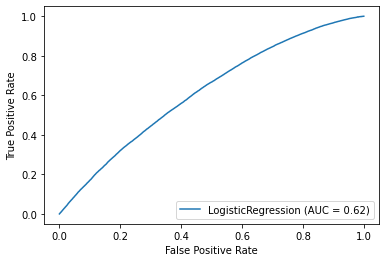

In [101]:
plot_roc_curve(model, X_test, y_test);

**Este modelo de regresion logistica NO es bueno ya que la tasa de falsos positivos llega a 1 cuando la tasa de verdaderos positivos llega a  1**

In [101]:
y_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

In [102]:
roc_auc_score(y_test, y_proba)

0.6165994739717993

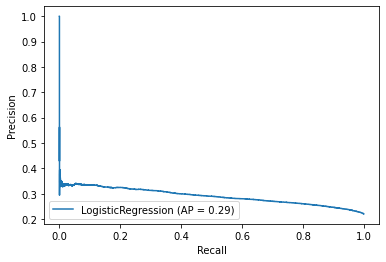

In [103]:
plot_precision_recall_curve(model, X_test, y_test)

**En est grafico vemos que este modelo de regresión logistica esta lejos del punto ideal ya que para recall = 1 cuando no habría falsos negativos la precision es muy baja**

In [104]:
precision, recall, thresholds = roc_curve(y_test, y_proba)

In [105]:
y_test_pred = model.predict(X_test)

In [106]:
f1_score(y_test, y_test_pred)

0.0

<AxesSubplot:>

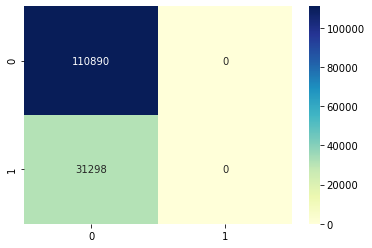

In [107]:
cm_train=confusion_matrix(y_test, y_test_pred)
s.heatmap(cm_train, annot=True ,cmap="YlGnBu", fmt="d")

**Este modelo de regresion logistica NO reconoce la clase 1**

# Usamos MinMaxScaler para la Regresion Logistica

In [108]:
scaler = MinMaxScaler()

In [109]:
transf_ds = scaler.fit_transform(dataset.iloc[:, :12])

In [110]:
transf_ds = pd.DataFrame(transf_ds)

In [111]:
X, y = transf_ds.iloc[:, 1:], transf_ds.iloc[:,0]

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [113]:
model = LogisticRegression(class_weight='balanced', random_state=0, solver='sag')

In [114]:
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Metricas Curvas ROC y matriz de confusión

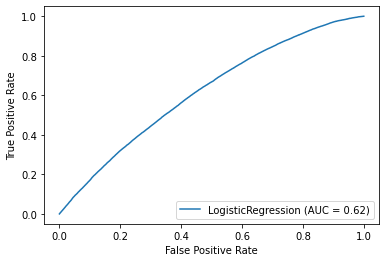

In [115]:
plot_roc_curve(model, X_test, y_test);

**Este modelo de regresion logistica con MinMax Scaler NO es bueno ya que la tasa de falsos positivos llega a 1 cuando la tasa de verdaderos positivos llega a  1**

In [116]:
y_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

In [117]:
roc_auc_score(y_test, y_proba)

0.6174886235955389

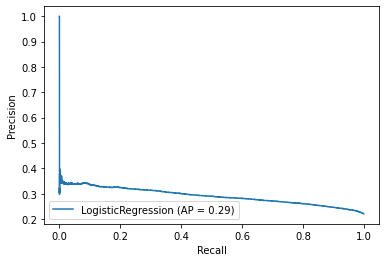

In [118]:
plot_precision_recall_curve(model, X_test, y_test)

**En est grafico vemos que este modelo de regresión logistica esta lejos del punto ideal ya que para recall = 1 cuando no habría falsos negativos la precision es muy baja**

In [119]:
precision, recall, thresholds = roc_curve(y_test, y_proba)

In [120]:
y_test_pred = model.predict(X_test)

In [121]:
f1_score(y_test, y_test_pred)

0.38837135791450506

<AxesSubplot:>

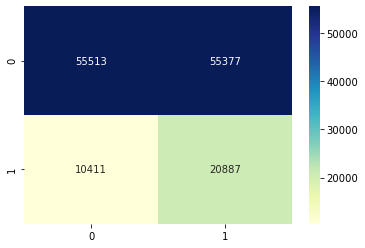

In [122]:
cm_test=confusion_matrix(y_test, y_test_pred)
s.heatmap(cm_test, annot=True ,cmap="YlGnBu", fmt="d")

**Observamos que hay una mejora al utilizar el MinMaxScaler para la regresion logistica ya que ahora reconoce la clase 1 pero empeora para la clase 0**

# Usamos SGD Classifier

In [123]:
X, y = dataset.iloc[:, 1:], dataset.EstadoDelTurno

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [125]:
model = SGDClassifier(loss = 'log' , random_state=0)

In [126]:
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Metricas Curvas ROC y matriz de confusión

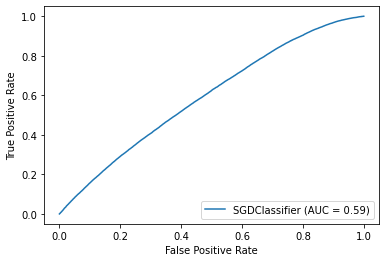

In [127]:
plot_roc_curve(model, X_test, y_test);

**Este modelo de SGDClassifier NO es bueno ya que la tasa de falsos positivos llega a 1 cuando la tasa de verdaderos positivos llega a  1**

In [128]:
y_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

In [129]:
roc_auc_score(y_test, y_proba)

0.5932535214691909

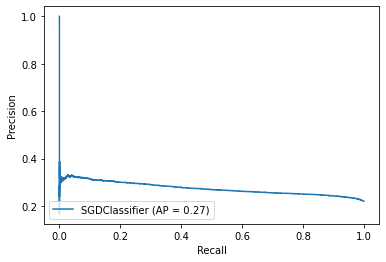

In [130]:
plot_precision_recall_curve(model, X_test, y_test)

**Este modelo SGDClassifier no seria bueno según esta relación entre recall y precision ya que para recall = 1 cuando no habría falsos negativos la precision es muy baja**

In [131]:
precision, recall, thresholds = roc_curve(y_test, y_proba)

In [132]:
y_test_pred = model.predict(X_test)

In [133]:
f1_score(y_test, y_test_pred)

0.005947484973109775

<AxesSubplot:>

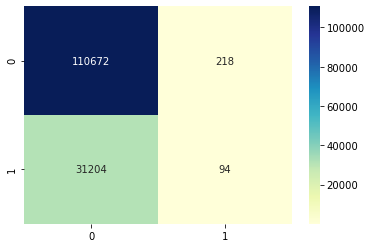

In [134]:
cm_test=confusion_matrix(y_test, y_test_pred)
s.heatmap(cm_test, annot=True ,cmap="YlGnBu", fmt="d")

**El SDGClassifier aunque comete un error considerable en la identificacion de la clase 1**

# Usamos MinMAxScaler para SGD Classifier

In [135]:
scaler = MinMaxScaler()

In [136]:
transf_ds = scaler.fit_transform(dataset.iloc[:, :12])

In [137]:
transf_ds = pd.DataFrame(transf_ds)

In [138]:
X, y = transf_ds.iloc[:, 1:], transf_ds.iloc[:,0]

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [140]:
model = SGDClassifier(loss = 'log', power_t = 0.7, random_state=42)

In [141]:
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Metricas Curvas ROC y matriz de confusión

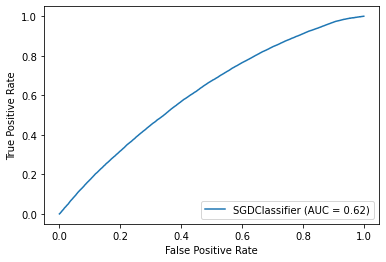

In [142]:
plot_roc_curve(model, X_test, y_test);

**Este modelo de SGDClassifier con MinMaxScaler NO es bueno ya que la tasa de falsos positivos llega a 1 cuando la tasa de verdaderos positivos llega a  1**

In [143]:
y_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

In [144]:
roc_auc_score(y_test, y_proba)

0.6183404929909093

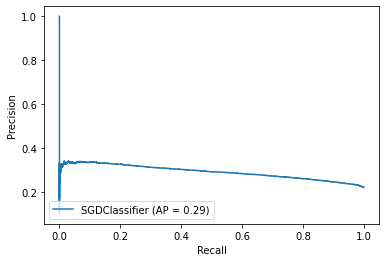

In [145]:
plot_precision_recall_curve(model, X_test, y_test)

**Este modelo SGDClassifier con MinMaxScaler NO seria bueno según esta relación entre recall y precision ya que para recall = 1 cuando no habría falsos negativos la precision es muy baja**

In [146]:
precision, recall, thresholds = roc_curve(y_test, y_proba)

In [147]:
y_test_pred = model.predict(X_test)

In [148]:
f1_score(y_test, y_test_pred)

0.0

<AxesSubplot:>

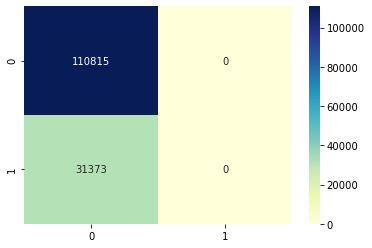

In [149]:
cm_test=confusion_matrix(y_test, y_test_pred)
s.heatmap(cm_test, annot=True ,cmap="YlGnBu", fmt="d")

**El uso del MinMaxScaler para el moldeo SDGClassifier empeora los resultados**

# Clasificador Polinomial

In [150]:
X, y = dataset.iloc[:, 1:], dataset.EstadoDelTurno

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [152]:
model = make_pipeline(
    PolynomialFeatures(degree= 3, interaction_only=False, include_bias=True),
    LogisticRegression()
)
model.fit(X_train, y_train);

In [153]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Metricas Curvas ROC y matriz de confusión

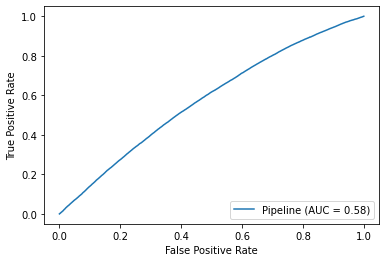

In [154]:
plot_roc_curve(model, X_test, y_test);

**Este modelo clasificador polinomial NO es bueno ya que la tasa de falsos positivos llega a 1 cuando la tasa de verdaderos positivos llega a  1**

In [155]:
y_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

In [156]:
roc_auc_score(y_test, y_proba)

0.578879462484571

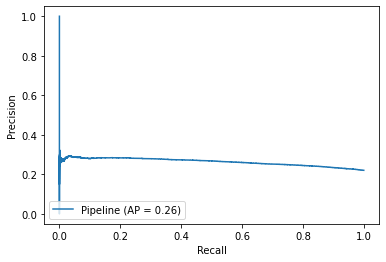

In [157]:
plot_precision_recall_curve(model, X_test, y_test)

**El clasificador polinomial no seria bueno según esta relación entre recall y precision ya que para recall = 1 cuando no habría falsos negativos la precision es muy baja**

In [158]:
precision, recall, thresholds = roc_curve(y_test, y_proba)

In [159]:
y_test_pred = model.predict(X_test)

In [160]:
f1_score(y_test, y_test_pred)

0.0026027614664338996

<AxesSubplot:>

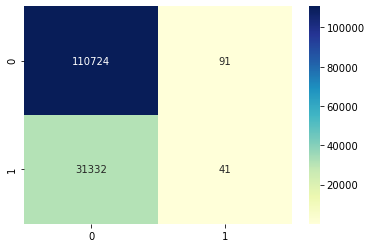

In [161]:
cm_train=confusion_matrix(y_test, y_test_pred)
s.heatmap(cm_train, annot=True ,cmap="YlGnBu", fmt="d")

**El clasificador polinomial comete error en la identificacion de la clase 1**

# Usamos MinMaxScaler para el Classificador Polinomial

In [162]:
scaler = MinMaxScaler()

In [163]:
transf_ds = scaler.fit_transform(dataset.iloc[:, :12])

In [164]:
transf_ds = pd.DataFrame(transf_ds)

In [165]:
X, y = transf_ds.iloc[:, 1:], transf_ds.iloc[:,0]

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [167]:
model = make_pipeline(
    PolynomialFeatures(degree= 4, interaction_only=False, include_bias=True),
    LogisticRegression()
)

In [168]:
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Metricas Curvas ROC y matriz de confusión

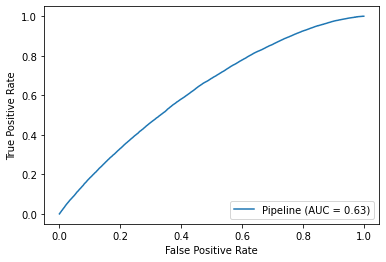

In [169]:
plot_roc_curve(model, X_test, y_test);

**Este modelo Clasificador Polinomial con MinMax Scaler NO es bueno ya que la tasa de falsos positivos llega a 1 cuando la tasa de verdaderos positivos llega a  1**

In [170]:
y_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

In [171]:
roc_auc_score(y_test, y_proba)

0.6294250264077018

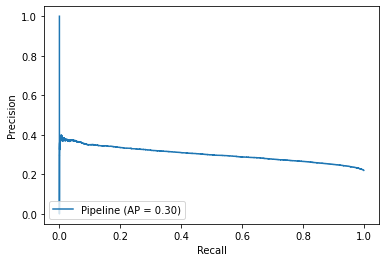

In [172]:
plot_precision_recall_curve(model, X_test, y_test)

**Este modelo Regresion Lineal no seria bueno según esta relación entre recall y precision ya que para recall = 1 cuando no habría falsos negativos la precision es muy baja**

In [173]:
precision, recall, thresholds = roc_curve(y_test, y_proba)

In [174]:
f1_score(y_test, y_test_pred)

0.0002555012615374789

In [175]:
y_test_pred = model.predict(X_test)

In [176]:
cm_test=confusion_matrix(y_test, y_test_pred)

<AxesSubplot:>

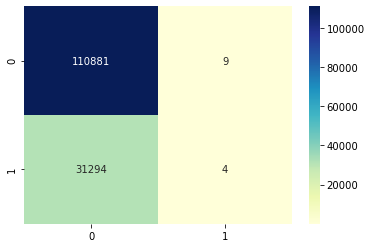

In [177]:
s.heatmap(cm_test, annot=True ,cmap="YlGnBu", fmt="d")

**Este modelo de Clasificador Polinomial con MinMaxScaler es malo porque a pesar de que clasifica bien la clase 0 clasifica mal la clase 1**

# Decision Tree Classifier

In [178]:
X, y = dataset.iloc[:, 1:], dataset.EstadoDelTurno

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [180]:
clf = DecisionTreeClassifier(max_depth=20, criterion='gini', random_state=0)
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=20, random_state=0)

In [181]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [182]:
accuracy_score(y_test,y_test_pred)

0.7498839564520212

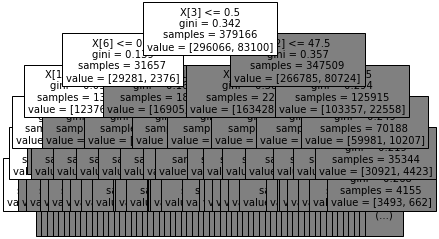

In [183]:
plot_tree(clf, max_depth = 5, fontsize=10);

# Metricas Curvas ROC y matriz de confusión

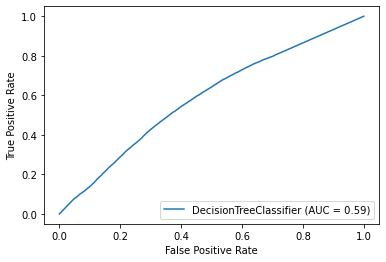

In [184]:
plot_roc_curve(clf, X_test, y_test);

**Este modelo DecisionTreeClassifier NO es bueno ya que la tasa de falsos positivos llega a 1 cuando la tasa de verdaderos positivos llega a  1**

In [185]:
y_proba = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

In [186]:
roc_auc_score(y_test, y_proba)

0.5876843067049579

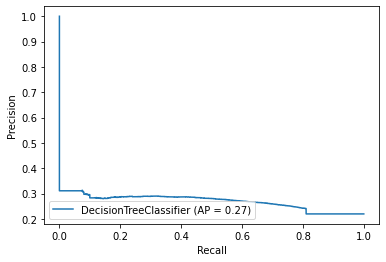

In [187]:
plot_precision_recall_curve(clf, X_test, y_test)

**El DecisionTreeClassifier seria medianamente bueno de acuerdo a este grafico ya que se acerca a una precision de 1 pero para un recall muy bajo o sea con muchos falsos negativos**

In [188]:
precision, recall, thresholds = roc_curve(y_test, y_proba)

In [189]:
f1_score(y_test, y_test_pred)

0.14914767629642922

In [190]:
y_test_pred = clf.predict(X_test)

In [191]:
cm_test=confusion_matrix(y_test, y_test_pred)

<AxesSubplot:>

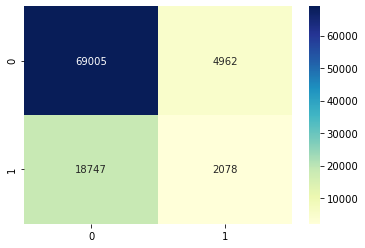

In [192]:
s.heatmap(cm_test, annot=True ,cmap="YlGnBu", fmt="d")

**Este modelo Decision Tree Classifier tiene un problema para reconocer la clase 1**

# Usamos MinMaxScaler para DecisionTreeClassifier

In [193]:
scaler = MinMaxScaler()

In [194]:
transf_ds = scaler.fit_transform(dataset.iloc[:, :12])

In [195]:
transf_ds = pd.DataFrame(transf_ds)

In [196]:
X, y = transf_ds.iloc[:, 1:], transf_ds.iloc[:,0]

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [198]:
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)

# Metricas Curvas ROC y matriz de confusión

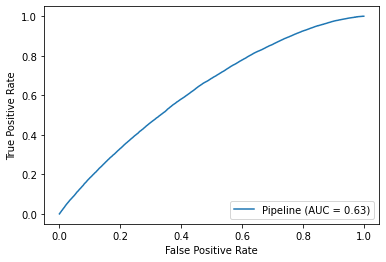

In [199]:
plot_roc_curve(model, X_test, y_test);

**El DecisionTreeClassifier con MinMax Scaler NO es bueno ya que la tasa de falsos positivos llega a 1 cuando la tasa de verdaderos positivos llega a  1** 

In [203]:
y_proba = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

In [204]:
roc_auc_score(y_test, y_proba)

0.5855136782424515

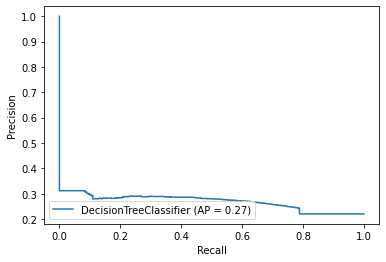

In [205]:
plot_precision_recall_curve(clf, X_test, y_test)

**El DecisionTreeClassifier con MinMAxScaler no seria bueno de acuerdo a este grafico ya que se acerca a un recall muy bajo o sea con muchos falsos negativos para una precision de 1**

In [206]:
precision, recall, thresholds = roc_curve(y_test, y_proba)

In [207]:
f1_score(y_test, y_test_pred)

0.15967850588863855

In [208]:
y_test_pred = clf.predict(X_test)

In [209]:
cm_test=confusion_matrix(y_test, y_test_pred)

<AxesSubplot:>

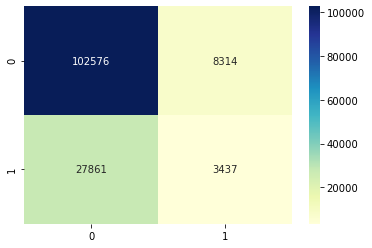

In [210]:
s.heatmap(cm_test, annot=True ,cmap="YlGnBu", fmt="d")

**Este modelo DecisionTreeClassifier con MinMAxScaler mejora muy poco y sigue cometiendo un error considerable en clasificar la clase 1**

# Random Forest

In [211]:
X, y = dataset.iloc[:, 1:], dataset.EstadoDelTurno

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [213]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Metricas Curvas ROC y matriz de confusión

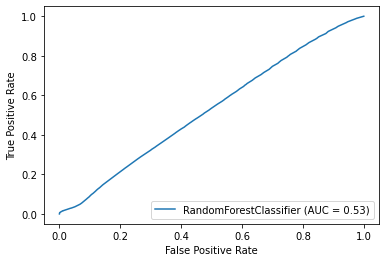

In [214]:
plot_roc_curve(model, X_test, y_test);

**El RandomForestClassifier NO es bueno ya que la tasa de falsos positivos llega a 1 cuando la tasa de verdaderos positivos llega a 1** 

In [215]:
y_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

In [216]:
roc_auc_score(y_test, y_proba)

0.5262810584282608

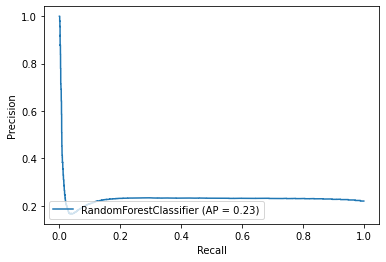

In [217]:
plot_precision_recall_curve(model, X_test, y_test)

**El RandomForestClassifier NO seria bueno de acuerdo a este grafico ya que se acerca a un recall muy bajo o sea con muchos falsos negativos para una precision de 1**

In [218]:
precision, recall, thresholds = roc_curve(y_test, y_proba)

In [219]:
f1_score(y_test, y_test_pred)

0.13923591090610116

In [220]:
y_test_pred = model.predict(X_test)

In [221]:
cm_test=confusion_matrix(y_test, y_test_pred)

<AxesSubplot:>

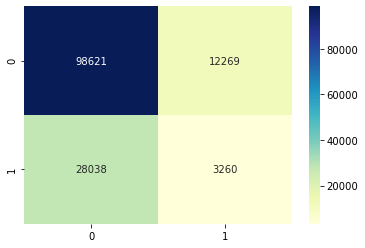

In [222]:
s.heatmap(cm_test, annot=True ,cmap="YlGnBu", fmt="d")

**Este modelo RandomForestClassifier comete un error considerable en clasificar la clase 1**

# Usamos MinMaxScaler para RandomForest

In [223]:
scaler = MinMaxScaler()

In [224]:
transf_ds = scaler.fit_transform(dataset.iloc[:, :12])

In [225]:
transf_ds = pd.DataFrame(transf_ds)

In [226]:
X, y = transf_ds.iloc[:, 1:], transf_ds.iloc[:,0]

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [228]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Metricas Curvas ROC y matriz de confusión

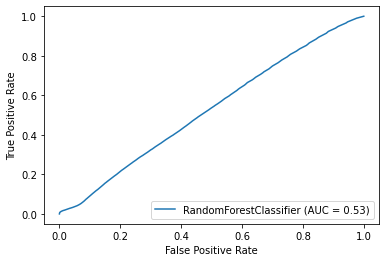

In [229]:
plot_roc_curve(model, X_test, y_test);

**El MinMaxScaler para Random Forest no seria bueno de acuerdo a este grafico ya que la tasa de falsos positivos llega a 1 cuando la tasa de verdaderos positivos llega a 1**

In [230]:
y_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

In [231]:
roc_auc_score(y_test, y_proba)

0.5267475483925965

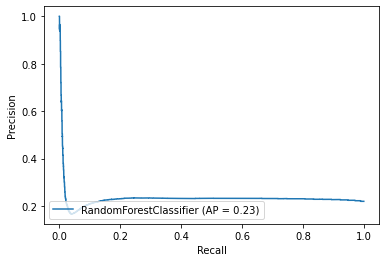

In [232]:
plot_precision_recall_curve(model, X_test, y_test)

**El MinMaxScaler para Random Forest no seria bueno de acuerdo a este grafico ya que cuando la precision es 1 el recall es muy bajo o sea con muchos falsos negativos**

In [233]:
precision, recall, thresholds = roc_curve(y_test, y_proba)

In [234]:
f1_score(y_test, y_test_pred)

0.139771391945305

In [235]:
y_test_pred = model.predict(X_test)

In [236]:
cm_test=confusion_matrix(y_test, y_test_pred)

<AxesSubplot:>

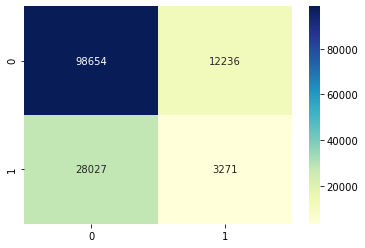

In [237]:
s.heatmap(cm_test, annot=True ,cmap="YlGnBu", fmt="d")

**Este modelo MinMaxScaler para Random Forest a pesar que de tiene problemas para reconocer la clase 1 pero tiene una mejor performance que los otros modelos antes considerados**

**Observaciones generales de los modelos y metricas utilizadas**

El parametro que hemos observado que influye mas es el porcentaje en que se divide 
los datos de entrenamiento y los de prueba

Observamos que el mejor modelo es usando MixMaxScaler ya que este hace una normalizacion de las features entre 0 y 1 y eso mejora los resultados

**Metricas:**  
Accuracy = (TP + TN) / (TP + TN + FP + FN )   
Mide el porcentaje de casos en el que el modelo ha acertado, pero no funciona bien cuando las clases estan desbalanceadas.

Precision = TP / (TP + FP) mide la calidad de la predicción del modelo  

Recall = TP / (TP + FN) mide la exhaustividad del modelo cuantas veces identifica correctamente

F1 = 2 * ( (precision * recall) / (precision + recall) ) es una media armonica entre precision y recall e indica que nos importa de igual forma la precisión y la exhaustividad  

La matriz de confusion nos indica que tipo de errores se cometen

El gráfico de Precision Recall nos fue muy util a la hora de determinar la bondad del modelo 
ya que el punto ideal es cuando tanto precision como recall valen 1.

Agregamos la matriz de confusión ya que nos brinda información respecto a cuan bueno es el modelo para lograr la clasificacion